In [ ]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install tqdm
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score

In [ ]:
import os
import json
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import pandas as pd

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/nlp-project/data'
BILLSUM_DATA_PATH = os.path.join(DATA_PATH, 'billsum_v4_1')

In [ ]:
# !cat /content/drive/MyDrive/nlp-project/data/billsum_v4_1/README.md

In [ ]:
def read_jsonl_file(FILE_PATH):
    X, y = [], []
    text_len, summary_len = [], []
    with open(FILE_PATH, 'r') as jsonfile:
        for line in jsonfile.readlines():
            json_obj = json.loads(line)
            X.append(json_obj['text'])
            y.append(json_obj['summary'])
            text_len.append(len(json_obj['text']))
            summary_len.append(len(json_obj['summary']))

            # text_len.append(len(sent_tokenize(json_obj['text'])))
            # summary_len.append(len(sent_tokenize(json_obj['summary'])))

    return X, y, text_len, summary_len

In [ ]:
X_train, y_train, text_train_len, sum_train_len = read_jsonl_file(os.path.join(BILLSUM_DATA_PATH, 'us_train_data_final_OFFICIAL.jsonl'))

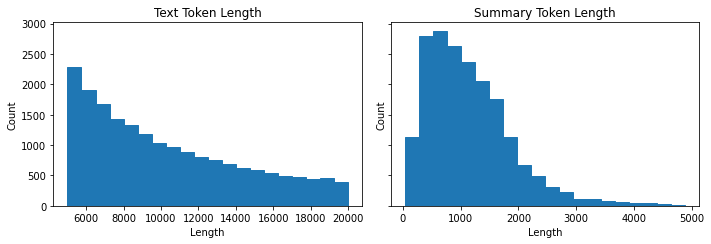

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(text_train_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Text Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(sum_train_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig('length.jpg')
plt.show()

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
TRAIN_DATA_FILE = os.path.join(BILLSUM_DATA_PATH, "us_train_data_final_OFFICIAL.jsonl")
TEST_DATA_FILE = os.path.join(BILLSUM_DATA_PATH, "us_test_data_final_OFFICIAL.jsonl")

dataset = load_dataset("json", data_files={
    "train": TRAIN_DATA_FILE,
    "test": TEST_DATA_FILE,
})

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-0a257b7a118a3705/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print('Train Size:', len(dataset['train']))
print('Test Size:', len(dataset['test']))
print('Total Size:', len(dataset['train']) + len(dataset['test']))

Train Size: 18949
Test Size: 3269
Total Size: 22218


In [ ]:
print('Mean Bill Length:', (sum(text_train_len) / len(text_train_len)))
print('Mean Summary Length:', (sum(sum_train_len) / len(sum_train_len)))

Mean Bill Length: 10274.5753337907
Mean Summary Length: 1146.4133199641142


In [ ]:
def preprocess_text(row):
    text = row['text']
    text = text.split('\n')
    text = list(map(lambda x: x.strip(), text))
    text = list(filter(lambda x: True if x else False, text))
    text = " ".join(text)
    row['text'] = text
    return row

In [ ]:
dataset = dataset.map(preprocess_text)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [ ]:
def convert_examples_to_features(batch):
    input_encodings = tokenizer(batch['text'], max_length=600, truncation=True)
    target_encodings = tokenizer(text_target=batch['summary'], max_length=40, truncation=True)
    
    return {
        "input_ids": input_encodings['input_ids'],
        "attention_mask": input_encodings['attention_mask'],
        "labels": target_encodings['input_ids']
    }

In [ ]:
dataset_pt = dataset.map(convert_examples_to_features, batched=True)

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_pt = dataset_pt.remove_columns(['bill_id', 'text', 'summary', 'title', 'text_len', 'sum_len'])
dataset_pt.set_format(type="torch", columns=columns)

In [ ]:
dataset_pt

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3269
    })
})

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='bart-billsum',
    num_train_epochs=2,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=False,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

In [ ]:
len(dataset_pt['train'][0]['input_ids'])

600

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_pt["train"],
    eval_dataset=dataset_pt["test"]
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 18949
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 2368
  Number of trainable parameters = 406290432
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,0.932500,1.025938
1000,0.837300,0.926803
1500,0.643400,0.878435
2000,0.622800,0.842390


***** Running Evaluation *****
  Num examples = 3269
  Batch size = 1
***** Running Evaluation *****
  Num examples = 3269
  Batch size = 1
***** Running Evaluation *****
  Num examples = 3269
  Batch size = 1
***** Running Evaluation *****
  Num examples = 3269
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2368, training_loss=0.8238635987446115, metrics={'train_runtime': 11546.1183, 'train_samples_per_second': 3.282, 'train_steps_per_second': 0.205, 'total_flos': 4.811070413615923e+16, 'train_loss': 0.8238635987446115, 'epoch': 2.0})

In [ ]:
trainer.save_model("./billsum-bart-2-epoch")

Saving model checkpoint to ./billsum-bart-2-epoch
Configuration saved in ./billsum-bart-2-epoch/config.json
Model weights saved in ./billsum-bart-2-epoch/pytorch_model.bin
tokenizer config file saved in ./billsum-bart-2-epoch/tokenizer_config.json
Special tokens file saved in ./billsum-bart-2-epoch/special_tokens_map.json


In [ ]:
!cp -r ./billsum-bart-2-epoch /content/drive/MyDrive/nlp-project/

In [ ]:
from tqdm import tqdm
from datasets import load_metric
import evaluate

In [ ]:
SAVED_MODEL_PATH = "/content/drive/MyDrive/nlp-project/billsum-bart-2-epoch"

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(SAVED_MODEL_PATH).to(device)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/45b6053e29f785d9a3b94aecfe8473b015e67156/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-cnn",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "force_bos_token_to_be_generated": t

In [ ]:
def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i:i+batch_size]

def evaluate_summaries(dataset, metric, model, tokenizer, batch_size=16, device=device, column_text="text", column_summary="summary"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)
    ):
        inputs = tokenizer(article_batch, max_length=600, truncation=True, padding="max_length", return_tensors="pt")
        summaries = model.generate(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8,
            num_beams=8,
            max_length=80
        )

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    
    score = metric.compute()
    return score

In [ ]:
# bleu_metric = evaluate.load("sacrebleu")
# score = evaluate_summaries(dataset['test'], bleu_metric, model, tokenizer, batch_size=8)


rouge_metric = evaluate.load("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]


score = evaluate_summaries(dataset['test'], rouge_metric, model, tokenizer, batch_size=8)

100%|██████████| 409/409 [26:04<00:00,  3.82s/it]


In [ ]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"BART"])

,rouge1,rouge2,rougeL,rougeLsum
BART,0.320892,0.22823,0.285447,0.285245


In [ ]:
#       rouge1	    rouge2	    rougeL	    rougeLsum
# BART	0.304243	0.208545	0.269411	0.269255

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 60}
sample_text = "SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. (a) Definitions.--In this section: (1) Business entity.--The term ``business entity'' means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. (2) Facility.--The term ``facility'' means any real property, including any building, improvement, or appurtenance. (3) Gross negligence.--The term ``gross negligence'' means voluntary and conscious conduct by a person with knowledge (at the time of the conduct) that the conduct is likely to be harmful to the health or well-being of another person. (4) Intentional misconduct.--The term ``intentional misconduct'' means conduct by a person with knowledge (at the time of the conduct) that the conduct is harmful to the health or well-being of another person. (5) Nonprofit organization.--The term ``nonprofit organization'' means-- (A) any organization described in section 501(c)(3) of the Internal Revenue Code of 1986 and exempt from tax under section 501(a) of such Code; or (B) any not-for-profit organization organized and conducted for public benefit and operated primarily for charitable, civic, educational, religious, welfare, or health purposes. (6) State.--The term ``State'' means each of the several States, the District of Columbia, the Commonwealth of Puerto Rico, the Virgin Islands, Guam, American Samoa, the Northern Mariana Islands, any other territory or possession of the United States, or any political subdivision of any such State, territory, or possession. (b) Limitation on Liability.-- (1) In general.--Subject to subsection (c), a business entity shall not be subject to civil liability relating to any injury or death occurring at a facility of the business entity in connection with a use of such facility by a nonprofit organization if-- (A) the use occurs outside of the scope of business of the business entity; (B) such injury or death occurs during a period that such facility is used by the nonprofit organization; and (C) the business entity authorized the use of such facility by the nonprofit organization. (2) Application.--This subsection shall apply-- (A) with respect to civil liability under Federal and State law; and (B) regardless of whether a nonprofit organization pays for the use of a facility. (c) Exception for Liability.--Subsection (b) shall not apply to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or intentional misconduct, including any misconduct that-- (1) constitutes a crime of violence (as that term is defined in section 16 of title 18, United States Code) or act of international terrorism (as that term is defined in section 2331 of title 18) for which the defendant has been convicted in any court; (2) constitutes a hate crime (as that term is used in the Hate Crime Statistics Act (28 U.S.C. 534 note)); (3) involves a sexual offense, as defined by applicable State law, for which the defendant has been convicted in any court; or (4) involves misconduct for which the defendant has been found to have violated a Federal or State civil rights law. (d) Superseding Provision.-- (1) In general.--Subject to paragraph (2) and subsection (e), this Act preempts the laws of any State to the extent that such laws are inconsistent with this Act, except that this Act shall not preempt any State law that provides additional protection from liability for a business entity for an injury or death with respect to which conditions under subparagraphs (A) through (C) of subsection (b)(1) apply. (2) Limitation.--Nothing in this Act shall be construed to supersede any Federal or State health or safety law. (e) Election of State Regarding Nonapplicability.--This Act shall not apply to any civil action in a State court against a business entity in which all parties are citizens of the State if such State enacts a statute-- (1) citing the authority of this subsection; (2) declaring the election of such State that this Act shall not apply to such civil action in the State; and (3) containing no other provision."
reference = "Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: (1) the use occurs outside the scope of business of the business entity; (2) such injury or death occurs during a period that such facility is used by such organization; and (3) the business entity authorized the use of such facility by the organization. Makes this Act inapplicable to an injury or death that results from an act or omission of a business entity that constitutes gross negligence or intentional misconduct, including misconduct that: (1) constitutes a hate crime or a crime of violence or act of international terrorism for which the defendant has been convicted in any court; or (2) involves a sexual offense for which the defendant has been convicted in any court or misconduct for which the defendant has been found to have violated a Federal or State civil rights law. Preempts State laws to the extent that such laws are inconsistent with this Act, except State law that provides additional protection from liability. Specifies that this Act shall not be construed to supersede any Federal or State health or safety law. Makes this Act inapplicable to any civil action in a State court against a business entity in which all parties are citizens of the State if such State, citing this Act's authority and containing no other provision, enacts a statute declaring the State's election that this Act shall not apply to such action in the State."

In [ ]:
inputs = tokenizer(sample_text, max_length=600, truncation=True, padding="max_length", return_tensors="pt")
summaries = model.generate(
    input_ids=inputs["input_ids"].to(device),
    attention_mask=inputs["attention_mask"].to(device),
    length_penalty=0.8,
    num_beams=8,
    max_length=300
)
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

In [ ]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries)

Dialogue:
SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES TO NONPROFIT ORGANIZATIONS. (a) Definitions.--In this section: (1) Business entity.--The term ``business entity'' means a firm, corporation, association, partnership, consortium, joint venture, or other form of enterprise. (2) Facility.--The term ``facility'' means any real property, including any building, improvement, or appurtenance. (3) Gross negligence.--The term ``gross negligence'' means voluntary and conscious conduct by a person with knowledge (at the time of the conduct) that the conduct is likely to be harmful to the health or well-being of another person. (4) Intentional misconduct.--The term ``intentional misconduct'' means conduct by a person with knowledge (at the time of the conduct) that the conduct is harmful to the health or well-being of another person. (5) Nonprofit organization.--The term ``nonprofit organization'' means-- (A) any organization described in section 501(c)(3) of the Inte